# Hate Speech Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import io

In [2]:
data = pd.read_csv("data/english_dataset.txt")

print(data.head())
print(data.shape)

      text_id                                               text task_1  \
0  hasoc_en_1  #DhoniKeepsTheGlove | WATCH: Sports Minister K...    NOT   
1  hasoc_en_2  @politico No. We should remember very clearly ...    HOF   
2  hasoc_en_3  @cricketworldcup Guess who would be the winner...    NOT   
3  hasoc_en_4  Corbyn is too politically intellectual for #Bo...    NOT   
4  hasoc_en_5  All the best to #TeamIndia for another swimmin...    NOT   

  task_2 task_3  
0   NONE   NONE  
1   HATE    TIN  
2   NONE   NONE  
3   NONE   NONE  
4   NONE   NONE  
(5852, 5)


In [3]:
def clean_text(input, regex):
    words_to_be_removed = re.findall(regex, input)
  
    for i in words_to_be_removed:
        input = re.sub(i, "", input)
    
    return input

In [4]:
cleaned_data = pd.DataFrame(np.vectorize(clean_text)(data['text'], "@[\w]*"), columns=['text'])
cleaned_data['task_1'] = data['task_1']
cleaned_data['task_2'] = data['task_2']
cleaned_data['task_3'] = data['task_3']

In [5]:
cleaned_data['text'].str.replace("[^a-zA-Z#]", " ")
cleaned_data.head()

,text,task_1,task_2,task_3
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
1,No. We should remember very clearly that #Ind...,HOF,HATE,TIN
2,Guess who would be the winner of this #CWC19?...,NOT,NONE,NONE
3,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
4,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE


## More Preprocessing of Data

Since, Deep Learning methods are being used we are not going to Lemmatize or Stem the data.

## Wordcloud for all the data

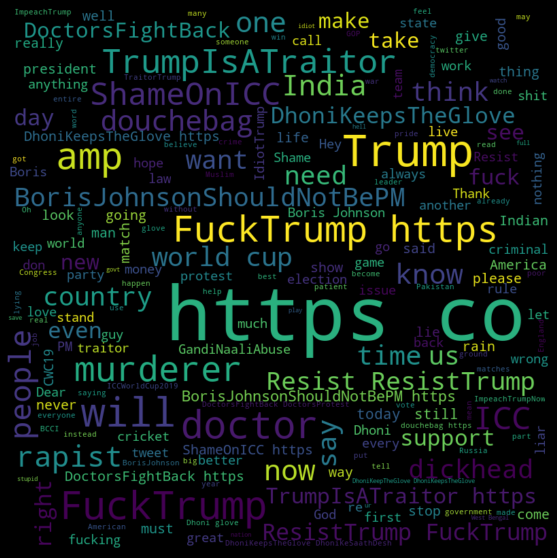

In [6]:
from wordcloud import WordCloud

all_words = " ".join(text for text in cleaned_data['text'])
wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(all_words)

plt.figure( figsize=(20,10), facecolor='k')
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### NOT labelled data

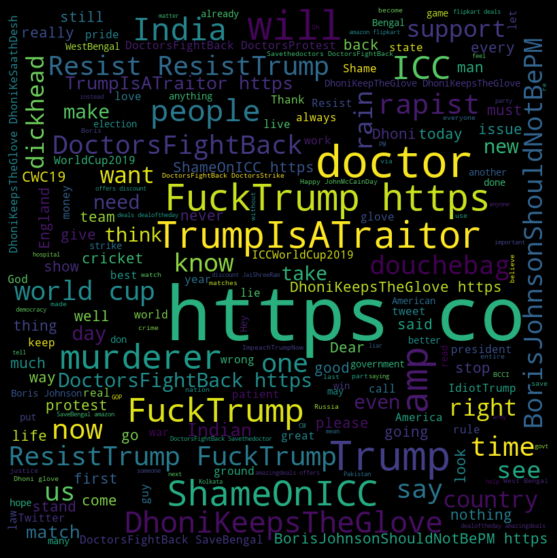

In [7]:
data_filter = cleaned_data['task_1'].isin(['NOT'])

NOT_data = cleaned_data[data_filter]

NOT_words = ' '.join([text for text in NOT_data['text']])

NOT_wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(NOT_words)

plt.figure(figsize=(20, 10), facecolor='k')
plt.tight_layout(pad=0)
plt.imshow(NOT_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### HOF labelled Data


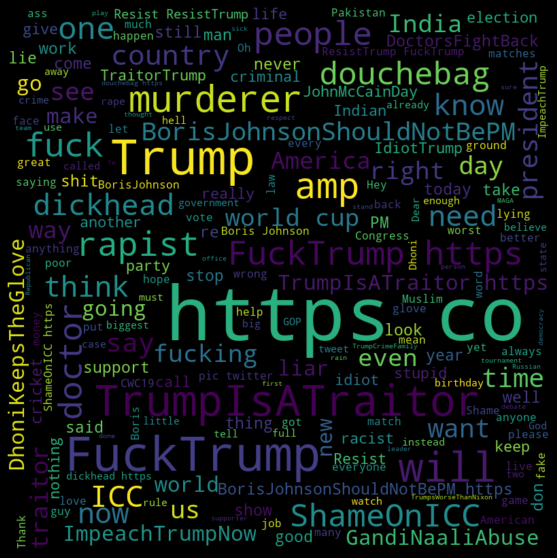

In [8]:
data_filter = cleaned_data['task_1'].isin([('HOF')])

data = cleaned_data[data_filter]

HOF_text = ' '.join([text for text in data['text']])

HOF_wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(HOF_text)

plt.figure(figsize=(20, 10), facecolor = 'k')
plt.tight_layout(pad=0)
plt.imshow(HOF_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
text = cleaned_data['text']

lengths = []
for word in text:
    lengths.append(len(word))

AVG_LENGTH = int(sum(lengths)/len(lengths))
print(AVG_LENGTH)

166


In [10]:
from keras_preprocessing.text import Tokenizer

rows, columns = cleaned_data.shape

tokenizer = Tokenizer(num_words=rows, lower=True)

In [11]:
from sklearn.model_selection import train_test_split

cleaned_data.head()

X = cleaned_data['text']
Y = cleaned_data['task_1']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [12]:
tokenizer.fit_on_texts(x_train)
train_index = tokenizer.texts_to_sequences(x_train)

flattened_train_data = [item for item in train_index]

In [13]:
from keras.preprocessing.sequence import pad_sequences

padded_train_data = pad_sequences(flattened_train_data, maxlen=AVG_LENGTH)

print(padded_train_data[:5], padded_train_data.shape)

Using TensorFlow backend.


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
   441  252  625    7  178  520  840  321   15   84  108   29]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
 

In [14]:
from keras.layers import Input, Dense, Embedding, LSTM, Dropout
from keras.models import Model
from keras.initializers import Constant
from keras import metrics

In [15]:
embeddings_Glove = dict()

test = open("data/glove.twitter.27B.200d.txt", encoding = 'utf8')
for line in test:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_Glove[word] = coefs
test.close()

In [16]:
embedding_matrix = np.zeros((rows, 200))
for word, index in tokenizer.word_index.items():
    if index >= rows:
        continue
    else:
        embedding_vector = embeddings_Glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
def Model_tweet():
    input_layer = Input(shape=(AVG_LENGTH,))
    embedding = Embedding(input_dim=rows, output_dim=200, embeddings_initializer=Constant(embedding_matrix), trainable=False)(input_layer)

    lstm1 = LSTM(units=10, return_sequences=False)(embedding)

    dropout = Dropout(0.2)(lstm1)
    dense = Dense(output_dim = 3, init='uniform', activation = 'relu')(dropout)
    output = Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid')(dense)

    model = Model(inputs = input_layer, outputs=output)
    return model

In [18]:
y_train_data = y_train.map({"HOF" : 1, "NOT" : 0})
y_train_data

2942    0
234     0
5511    1
726     0
1037    1
       ..
5482    1
5197    1
2855    1
747     0
783     0
Name: task_1, Length: 4681, dtype: int64

In [19]:
X_trainPadding, X_testPadding, y_trainPadding, y_testPadding = train_test_split(padded_train_data, y_train_data, test_size=0.2)

In [20]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_trainPadding), y_trainPadding)
class_weights

array([0.81003894, 1.30635031])

In [21]:
classifier = Model_tweet()
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
classifier.summary()

history = classifier.fit(X_trainPadding, y_trainPadding, validation_data = (X_testPadding, y_testPadding), class_weight = class_weights, batch_size=100, nb_epoch = 100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 166)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 166, 200)          1170400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                8440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_2 (Dense) 

/home/himmeldreng/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=3, kernel_initializer="uniform")`
  
/home/himmeldreng/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  if __name__ == '__main__':
/home/himmeldreng/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """



Train on 3744 samples, validate on 937 samples
Epoch 1/100
3744/3744 [==============================] - 2s 556us/step - loss: 0.6904 - acc: 0.6149 - val_loss: 0.6855 - val_acc: 0.6179
Epoch 2/100
3744/3744 [==============================] - 2s 469us/step - loss: 0.6780 - acc: 0.6173 - val_loss: 0.6693 - val_acc: 0.6179
Epoch 3/100
3744/3744 [==============================] - 2s 487us/step - loss: 0.6642 - acc: 0.6173 - val_loss: 0.6601 - val_acc: 0.6179
Epoch 4/100
3744/3744 [==============================] - 2s 430us/step - loss: 0.6588 - acc: 0.6173 - val_loss: 0.6542 - val_acc: 0.6179
Epoch 5/100
3744/3744 [==============================] - 2s 411us/step - loss: 0.6509 - acc: 0.6173 - val_loss: 0.6446 - val_acc: 0.6179
Epoch 6/100
3744/3744 [==============================] - 2s 415us/step - loss: 0.6407 - acc: 0.6173 - val_loss: 0.6337 - val_acc: 0.6179
Epoch 7/100
3744/3744 [==============================] - 2s 459us/step - loss: 0.6342 - acc: 0.6173 - val_loss: 0.6266 - val_acc: 

3744/3744 [==============================] - 2s 485us/step - loss: 0.3072 - acc: 0.8897 - val_loss: 0.8760 - val_acc: 0.6201
Epoch 59/100
3744/3744 [==============================] - 2s 472us/step - loss: 0.3113 - acc: 0.8865 - val_loss: 0.9083 - val_acc: 0.6403
Epoch 60/100
3744/3744 [==============================] - 2s 428us/step - loss: 0.3102 - acc: 0.8892 - val_loss: 0.9131 - val_acc: 0.6329
Epoch 61/100
3744/3744 [==============================] - 2s 427us/step - loss: 0.3031 - acc: 0.8918 - val_loss: 0.9290 - val_acc: 0.6339
Epoch 62/100
3744/3744 [==============================] - 2s 426us/step - loss: 0.3130 - acc: 0.8841 - val_loss: 0.9350 - val_acc: 0.6179
Epoch 63/100
3744/3744 [==============================] - 2s 429us/step - loss: 0.3109 - acc: 0.8822 - val_loss: 0.9412 - val_acc: 0.6403
Epoch 64/100
3744/3744 [==============================] - 2s 441us/step - loss: 0.2910 - acc: 0.8945 - val_loss: 0.9780 - val_acc: 0.6318
Epoch 65/100
3744/3744 [=======================

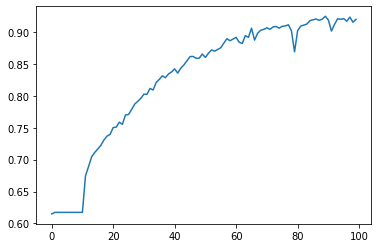

The accuracy is 0.9249466061592102


In [22]:
plt.plot(history.history['acc'])
plt.show()

accuracy = max(history.history['acc'])

print(f'The accuracy is {accuracy}')